In [59]:
from google.colab import drive
drive.mount('/content/drive')

# Change the dir_path to your directory
dir_path = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


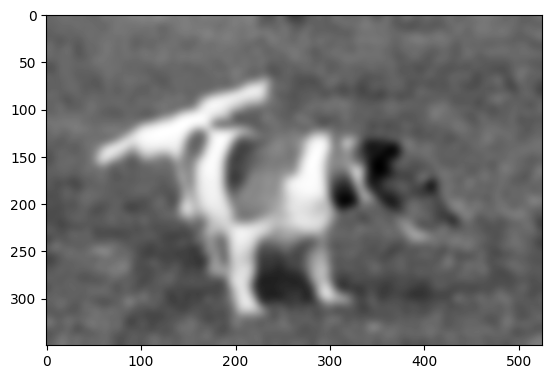

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from PIL import Image
from scipy.ndimage import convolve
from scipy.signal import convolve2d
from skimage.restoration import denoise_tv_chambolle

image = Image.open(dir_path + 'dog_on_grass.jpg')
img_gray = image.convert('L')
img_array = np.array(img_gray, dtype=np.float32) / 255.0  # Normalize the image
plt.imshow(img_gray, cmap='gray')

M, N = img_array.shape

# Define the blurring kernel, a Gaussian kernel can be used
kernel_size = (50, 50)  # This can be changed
sigma = 5.0
kernel = cv2.getGaussianKernel(kernel_size[0], sigma) * cv2.getGaussianKernel(kernel_size[1], sigma).T

# Blur the image
blurred_image = cv2.filter2D(img_array, -1, kernel)
plt.imshow(blurred_image, cmap='gray')


0 0.4942449840992771


<ipython-input-61-549862f6cb72>:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_tv_chambolle(image, weight=sigma, multichannel=False)


2 0.006062369532203392
4 0.004084464947018735
6 0.002674161945085696
8 0.002098663054403181
10 0.002232277532890397
12 0.0025462036734556145
14 0.002169933774624731
16 0.0015961421247653756
18 0.0010572514037072705
19


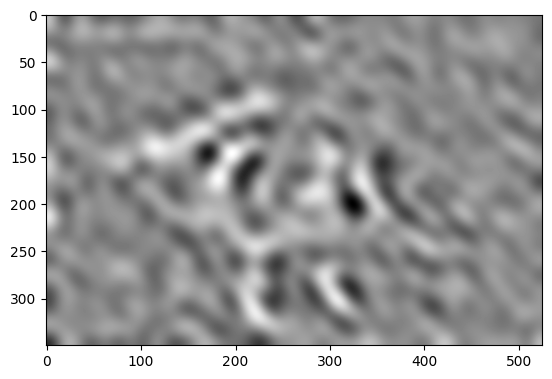

In [61]:
# My Version

def denoiser(image, sigma):
    return denoise_tv_chambolle(image, weight=sigma, multichannel=False)

def apply_convolution(image, kernel):
    return convolve2d(image, kernel, boundary='wrap', mode='same')

def update_x(x_prev, u_prev, v_prev, rho, kernel):
    # A = apply_convolution(x_prev, kernel)
    # rhs = np.fft.fftn(A + rho * (v_prev-u_prev))
    # x = np.real(np.fft.ifftn(rhs / (np.abs(np.fft.fftn(x_prev))**2 + rho)))
    # return x
    A = apply_convolution(x_prev, kernel)
    rhs = np.fft.fftn(A + rho * (v_prev-u_prev))
    x = np.real(np.fft.ifftn(rhs / (np.abs(np.fft.fftn(x_prev))**2 + rho)))
    return x

def update_v(x, u_prev, lambd, rho):
    return denoiser(x + u_prev, np.sqrt(lambd / rho))

def update_u(x, v, u_prev):
    return u_prev + (x - v)

def calc_delta(n, x, x_prev, v, v_prev, u, u_prev):
    return 1/np.sqrt(n) * (np.linalg.norm(x-x_prev) + \
                           np.linalg.norm(v-v_prev) + \
                           np.linalg.norm(u-u_prev))

x_prev = np.zeros_like(blurred_image)
v_prev = v = 0.5*np.zeros_like(blurred_image)
u_prev = u = np.zeros_like(blurred_image)

x = np.array(blurred_image)
iteration = 100
rho = 0.0001
eta = 0.5
lambd = 0.01
gamma = 1.5
tol = 0.001

delta_value = calc_delta(M*N, x, x_prev, v, v_prev, u, u_prev)

k = 0
while delta_value >= tol and k < iteration:
    if k%2==0:
        print(k, delta_value)
    x_prev = x
    v_prev = v
    u_prev = u
    x = update_x(x_prev, u_prev, v_prev, rho, kernel)
    v = update_v(x, u_prev, lambd, rho)
    u = update_u(x, v, u_prev)

    delta_prev = delta_value
    delta_value = calc_delta(M*N, x, x_prev, v, v_prev, u, u_prev)

    if delta_value >= eta*delta_prev:
        rho = gamma*rho
    else:
        rho = rho

    k += 1

print(k)
plt.imshow(v, cmap='gray')
